# input data

In [5]:
import pandas as pd

data_files = '../sub43data/'

In [6]:

baseline = pd.read_csv(data_files + 'sub-43_ses-01_task-RLbaseline_run-1_space-fsLR_den-91k_bold_timeseries.tsv', delimiter='\t')
baseline.shape

(219, 998)

In [7]:
rs43_fname = 'sub-43_ses-01_task-rest_run-1_space-fsLR_den-91k_bold_timeseries.tsv'
rs = pd.read_csv(data_files + rs43_fname, delimiter='\t')
rs.shape

(297, 998)

In [8]:
learning_43_fname = 'sub-43_ses-01_task-RLlearning_run-1_space-fsLR_den-91k_bold_timeseries.tsv'
lrn = pd.read_csv(data_files + learning_43_fname, delimiter='\t')
lrn.shape

(609, 998)

In [9]:
rs.columns

Index(['7Networks_LH_Vis_1', '7Networks_LH_Vis_2', '7Networks_LH_Vis_3',
       '7Networks_LH_Vis_4', '7Networks_LH_Vis_5', '7Networks_LH_Vis_6',
       '7Networks_LH_Vis_7', '7Networks_LH_Vis_8', '7Networks_LH_Vis_9',
       '7Networks_LH_Vis_10',
       ...
       '7Networks_RH_Default_pCunPCC_11', '7Networks_RH_Default_pCunPCC_12',
       '7Networks_RH_Default_pCunPCC_13', '7Networks_RH_Default_pCunPCC_14',
       '7Networks_RH_Default_pCunPCC_15', '7Networks_RH_Default_pCunPCC_16',
       '7Networks_RH_Default_pCunPCC_17', '7Networks_RH_Default_pCunPCC_18',
       '7Networks_RH_Cont_pCun_2', '7Networks_RH_Cont_pCun_4'],
      dtype='object', length=998)

# atlas

In [14]:
import nibabel as nib
import numpy as np

atlas_files = '../atlas/Schaefer2018_1000Parcels_7Networks/'

atlas_lh = nib.freesurfer.read_annot(atlas_files + 'lh.Schaefer2018_1000Parcels_7Networks_order.annot')
surf_labels_lh = atlas_lh[0]
atlas_rh = nib.freesurfer.read_annot(atlas_files + 'rh.Schaefer2018_1000Parcels_7Networks_order.annot')
surf_labels_rh = atlas_rh[0]

In [15]:
surf_labels_rh[surf_labels_rh != 0] += 500  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

In [16]:
labels_lh = [x.decode() for x in atlas_lh[2]]
labels_rh = [x.decode() for x in atlas_rh[2]]
labels_rh.remove('Background+FreeSurfer_Defined_Medial_Wall')
regions = labels_lh + labels_rh

In [17]:
atlas_lh[1].shape

(501, 5)

In [18]:
REMOVED_REGIONS = set(regions) - set(rs.columns.tolist())
REMOVED_REGIONS

{'7Networks_RH_Cont_Cing_1',
 '7Networks_RH_Vis_33',
 'Background+FreeSurfer_Defined_Medial_Wall'}

## labels to plot surf 

it's also the mapping from 20484 2mm voxels to 1001 regions on brain surface

In [19]:
surf_labels

array([145, 214, 128, ..., 833, 833, 833], dtype=int32)

In [20]:
(surf_labels == 0).sum()

1743

In [21]:
(surf_labels == 1000).sum()

17

https://github.com/ThomasYeoLab/CBIG/blob/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv

## removing regions

In [22]:
removed_labels = [regions.index(r) for r in REMOVED_REGIONS]
removed_labels
# it's the plus one

[533, 903, 0]

In [23]:
for r in REMOVED_REGIONS:
    regions.remove(r)

len(regions)

998

## corr mat

In [27]:
from nilearn.connectome import ConnectivityMeasure

In [28]:
# resting state data
correlation_measure = ConnectivityMeasure(kind='correlation')
corr_mat = correlation_measure.fit_transform([rs.values])[0]

In [29]:
# baseline 
correlation_measure_baseline = ConnectivityMeasure(kind='correlation')
corr_mat_baseline = correlation_measure_baseline.fit_transform([baseline.values])[0]

In [30]:
# learning
correlation_measure_lrn = ConnectivityMeasure(kind='correlation')
corr_mat_lrn = correlation_measure_lrn.fit_transform([lrn.values])[0]

# conn matrix

In [32]:
# from nilearn import plotting

## reduced mat based on std

In [33]:
# Reduce matrix size, only for visualization purposes
mat_mask = np.where(np.std(corr_mat, axis=1) > 0.2)[0]
corr_mat_masked = corr_mat[mat_mask][:, mat_mask]
# Create corresponding region names
regions_list = ['%s_%s' % (h, r) for h in ['L', 'R'] for r in regions]
masked_regions = [regions_list[i] for i in mat_mask]

In [34]:
len(mat_mask)

636

In [35]:
mat_mask[:10] # e.g. no 5 and 6 

array([ 1,  2,  3,  4,  7,  8,  9, 10, 11, 12])

In [ ]:
# from matplotlib import pyplot as plt

# fig = plt.figure(figsize=(15,15))
# ax = plotting.plot_matrix(corr_mat_masked, labels=masked_regions,
#                                  vmax=0.8, vmin=-0.8, reorder=True,
#                                  figure=fig, # figure=(15, 15), 
#                                  )

# fig.savefig('con-mat.png')

## reordering

In [ ]:
# reordered_labels = [lbl.get_text() for lbl in ax.axes.get_xticklabels()]
# len(reordered_labels)
# regions[:5], reordered_labels[:5]
# str_regions = [str(r) for r in regions]
# regions_ordering = [str_regions.index(r) for r in reordered_labels]
# corr_mat_reordered = corr_mat[regions_ordering][:, regions_ordering]
# plotting.plot_matrix(corr_mat_reordered, figure=(15, 15),
#                         labels=reordered_labels, reorder=False,
#                         vmax=0.8, vmin=-0.8)

https://github.com/nilearn/nilearn/issues/1633

## baseline and learning respecting to rs 

now that we have the orders, we can input that to the next cond_data

In [ ]:
# corr_mat_baseline.shape
# corr_mat_baseline_reordered = corr_mat_baseline[regions_ordering][:, regions_ordering]

---

# plot surf

In [36]:
removed_labels

[533, 903, 0]

In [37]:
surf_labels

array([145, 214, 128, ..., 833, 833, 833], dtype=int32)

In [38]:
# Build Destrieux parcellation and mask
mask_removed = ~np.isin(surf_labels, removed_labels)

In [39]:
len(mask_removed), (mask_removed == False).sum()
# removed voxels due to being in removed regions

(20484, 1761)

In [40]:
len(set(surf_labels)), len(set(surf_labels[mask_removed]))

(1001, 998)

# Gradients

In [43]:
from brainspace.gradient import GradientMaps

In [45]:
gm_ref = GradientMaps(n_components=10, random_state=0, approach="pca")
gm_ref.fit(corr_mat, sparsity=0.9)

gm_aligned = GradientMaps(n_components=10, random_state=0, alignment="procrustes", approach="pca")
gm_aligned.fit([corr_mat, corr_mat_baseline, corr_mat_lrn],
reference=gm_ref.gradients_, 
sparsity=0.9)

# if reference is not specified, goes with mean


GradientMaps(alignment='procrustes', approach='pca', random_state=0)

---

# plot grads

In [46]:
from brainspace.utils.parcellation import map_to_labels

In [ ]:
# learning grads:

In [47]:
len(gm_aligned.aligned_)

3

In [48]:
grad = map_to_labels(gm_aligned.gradients_[2][:, 0], surf_labels, mask=mask_removed, fill=np.nan)
grad2 = map_to_labels(gm_aligned.gradients_[2][:, 1], surf_labels, mask=mask_removed, fill=np.nan)

In [49]:
# aligned

grad_aligned = map_to_labels(gm_aligned.aligned_[2][:, 0], surf_labels, mask=mask_removed, fill=np.nan)
grad2_aligned = map_to_labels(gm_aligned.aligned_[2][:, 1], surf_labels, mask=mask_removed, fill=np.nan)

## plot_hemishpheres

In [210]:
# from brainspace.plotting import plot_hemispheres
# plot_hemispheres(surf_lh=surf_lh, surf_rh=surf_rh,
# array_name=grad_data, 
# filename='subject 43 - baseline gradients',
#     size=(1200, 1500), color_bar=True, 
#     cmap=color_map,
#     zoom=1.5, label_text=text)

## surfplot

In [50]:
from brainspace.datasets import load_fsa5

surf_lh, surf_rh = load_fsa5()

In [207]:
from surfplot import Plot

def stack_surfplot(data_to_show, text_bar, color_map):
    p = Plot(surf_lh=surf_lh, surf_rh=surf_rh,
            size=(1600, 300),
            layout='row',
            label_text=[text_bar]
            )

    p.add_layer(
        data_to_show, cbar=True, cmap=color_map,  
    )

    fig = p.build()
    fig = p.render(offscreen=True)
    fig.show()

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
texts = ['Schaefer\n1000', '1st grad', '1st grad aligned', '2nd grad', '2nd grad aligned']
data = [surf_labels, grad, grad_aligned, grad2, grad2_aligned]
color_maps = ['tab20', 'viridis_r', 'viridis_r', 'viridis_r', 'viridis_r']

z = zip(data, texts, color_maps)

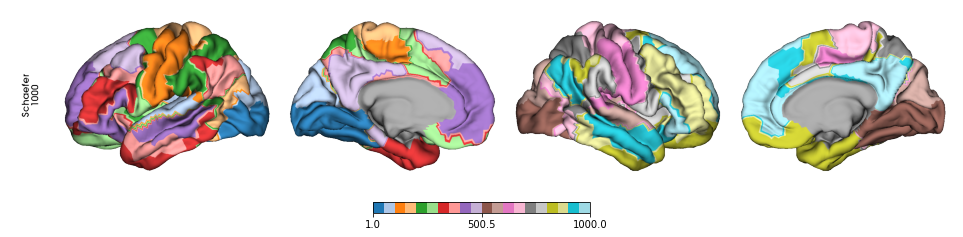

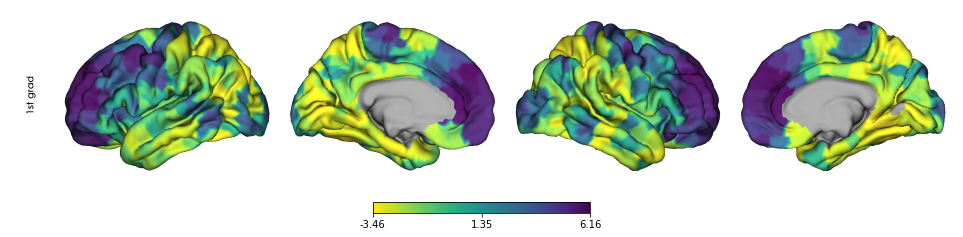

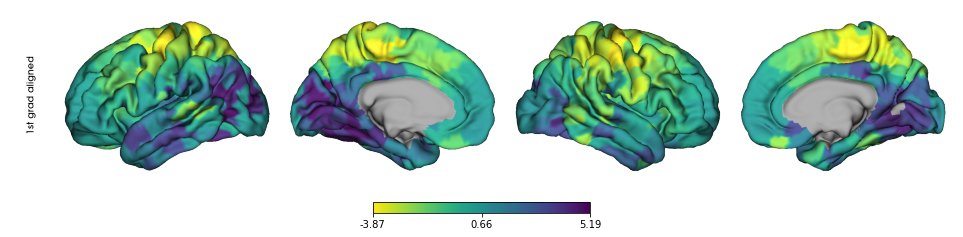

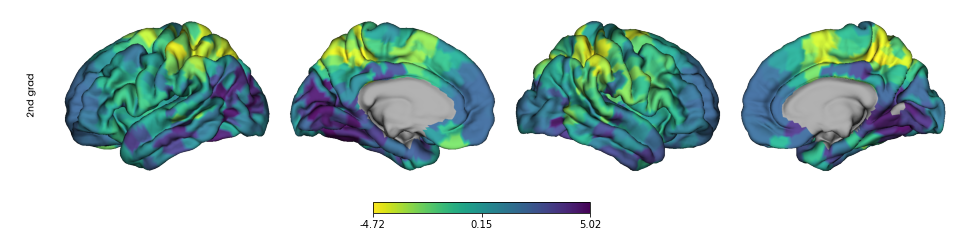

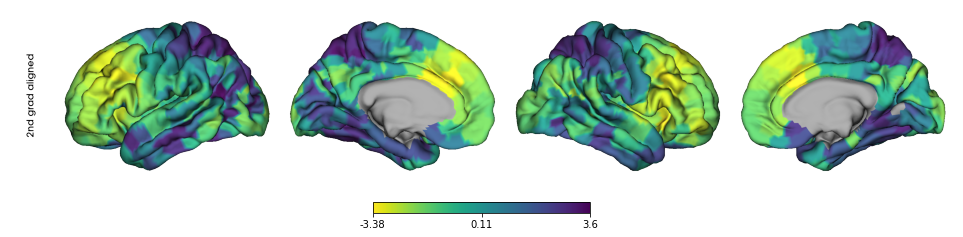

In [208]:
for data_to_show, text_bar, color_map in z:
    stack_surfplot(data_to_show, text_bar, color_map)